# Annual Messages to Congress on the State of the Union
Wikipedia:
The State of the Union Address (sometimes abbreviated to SOTU) is an annual message delivered by the president of the United States to the U.S. Congress near the beginning of each calendar year on the current condition of the nation. The message typically includes reports on the nation's budget, economy, news, agenda, achievements and the president's priorities and legislative proposals.

## Load Data

Set the path of stored data into `PATH`, if you dont have any data, run `Download.ipynb`

In [1]:
# import libraries
import csv
import warnings
warnings.filterwarnings("ignore")

In [2]:
PATH = 'SOTU_data' # path of stored data

Save Metadata into dicts/list/dataframes 

In [3]:
file_date = {} # a dict to store file_name : date map
date_list = []
# open metadata information 
with open(PATH + '/information.csv', 'r') as c:
    csv_reader = csv.reader(c)
    header = next(csv_reader)
    if header != None:
        for row in csv_reader:
            # save to file_date dict 
            file_date[row[0]] = row[2]
            date_list.append(row[2].split(', ')[-1])

Open stored txt files and save into a dict

In [4]:
file_document = {} # a dict to store file_name : document text map
for file_name in file_date.keys():
    with open(PATH + '/speaches/' + file_name) as f:
        content = ' '.join(f.read().splitlines())
    file_document[file_name] = content

a text sample (1000 first characters) from `0.txt` file:

In [5]:
doc_sample = file_document['0.txt'][0:1000]
doc_sample 

' To the Congress: In considering the State of the Union, the war and the peace that is to follow are naturally uppermost in the minds of all of us. This war must be waged—it is being waged—with the greatest and most persistent intensity. Everything we are and have is at stake. Everything we are and have will be given. American men, fighting far from home, have already won victories which the world will never forget. We have no question of the ultimate victory. We have no question of the cost. Our losses will be heavy. We and our allies will go on fighting together to ultimate total victory. We have seen a year marked, on the whole, by substantial progress toward victory, even though the year ended with a setback for our arms, when the Germans launched a ferocious counter-attack into Luxembourg and Belgium with the obvious objective of cutting our line in the center. Our men have fought with indescribable and unforgettable gallantry under most difficult conditions, and our German enemi

## Per-process Data

In [6]:
# import libraries
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [7]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def pre_process(text):
    # remove [Laughter] and [Applause]
    text = re.sub(r'(:?\[Laughter\]|\[Applause\])', '', text)
    text = text.lower()
    # remove non letters: (e.g, punctuations): [^a-zA-Z0-9_]
    # remove digit+ word+: 2nd
    # remove digit+ : 22
    # remove digit+ word+ digit+: 2nd2
    text = re.sub(r'[^a-zA-Z0-9_]|\b\d+\w*\d*\b', ' ', text)    
    # filter stopwords
    # lemmatize words: Returns the input word unchanged if it cannot be found in WordNet.
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

Apply `pre_process` function on data: unexpectedly fast

In [8]:
file_normlized_doc = {}
normlized_doc = []
for key in file_document.keys():
    n_doc = pre_process(file_document[key])
    file_normlized_doc[key] = n_doc
    normlized_doc.append(n_doc) 

## Process Data

In [20]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pyLDAvis.sklearn, pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

### LDA 
LDA is a generative statistical model for topic modeling. LDA is based on term counts and document counts. 

- `ngram_range`=(1,2), means the lower bound is 1 and upper boundary is 2 from the range of values for different word n-grams.
- `min_df`= 4, removes words with occurrence in less than 4 documents.
- `max_df` = 0.6, ignores the terms that have a document frequency strictly higher than 0.6.
- `max_features`=1000, selects 1000 top features by the score of term frequencey.
- `n_components` = 3, chooses number of topics=3

In [10]:
number_of_topics = 3 #number of topics

In [11]:
# a function to compute count vectorizer and LDA
def lda_costum(docs, n_topics=3):
    c_vectorizer_model = CountVectorizer(analyzer='word', ngram_range=(1,2), max_df=0.6, min_df=5, max_features=1000)
    cv_fit = c_vectorizer_model.fit_transform(docs)
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=100, n_jobs=-1)
    lda_model.fit(cv_fit)
    return lda_model, cv_fit, c_vectorizer_model
    
# a function to give words of each topic for LDA: number_show can be cahnged
def lda_display(lda_model, c_vectorizer_model):
    names = c_vectorizer_model.get_feature_names()
    number_show = 10
    for ind, topic in enumerate(lda_model.components_):
        topic_list = [names[i] for i in np.argsort(topic * -1)[:number_show]]
        print(f"Topic {ind}: {topic_list}")

# a function to plot the topics during the time
def costum_plot(model, model_fit, n_words = 30):
    
    time_series = []
    n_words = 30
    for index in range(number_of_topics):
        top_number_indices = np.argsort(model.components_ * -1)[index,:n_words]
        values = model_fit[:,top_number_indices].transpose().sum(axis=0)
        time_series.append(values)
        
    concatenate_values = np.concatenate(tuple(time_series))
    normlized_values = normalize(concatenate_values, norm='l1', axis=0)
    
    index_list = [f'Topic {ind}' for ind in range(number_of_topics)]
    df = pd.DataFrame(data=normlized_values.T, index=date_list, columns=index_list)

    plot = sns.lineplot(data=df)
    plt.setp(plot.get_xticklabels(), rotation=90)

Apply `lda_costum` function to compute topics and display the top 10 words in each topic using `lda_display` function.

In [12]:
lda_model, cv_fit, c_vectorizer_model = lda_costum(normlized_doc, n_topics=number_of_topics)
lda_display(lda_model, c_vectorizer_model)

Topic 0: ['shall', 'communist', 'labor', 'recommend', 'free world', 'recommendation', 'expenditure', 'united nation', 'fiscal', 'aggression']
Topic 1: ['proposed', 'oil', 'agency', 'employment', 'rural', 'state local', 'transportation', 'ensure', 'management', 'comprehensive']
Topic 2: ['tonight', 'thank', 'drug', 'terrorist', 'parent', 'college', 'pas', 'health care', 'iraq', 'dream']


Apply `costum_plot` function to see how much each topic is spoken during the time, we consider top 30 words from each topic

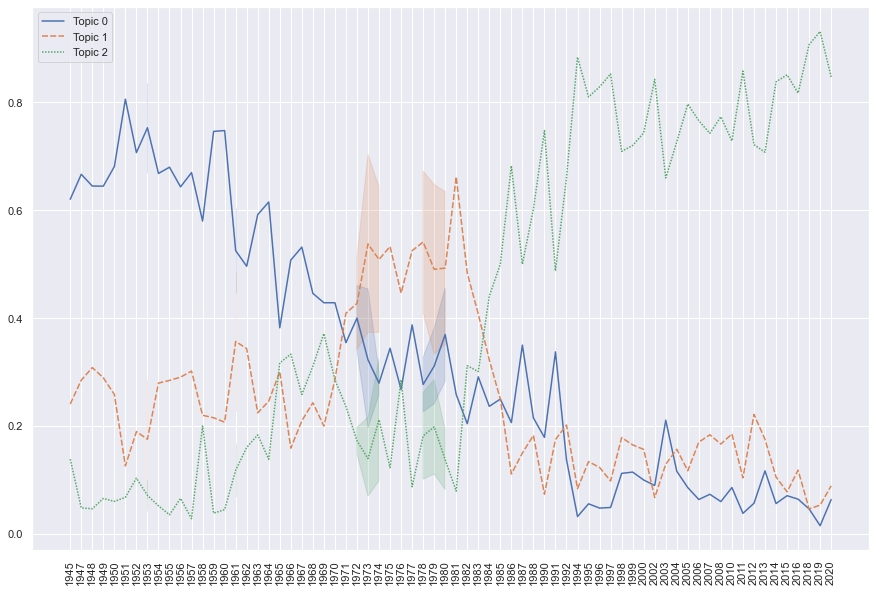

In [21]:
costum_plot(lda_model, cv_fit, 30)

Use `pyLDAvis` to plot Intertopic Distance Map of Topics and Top-30 Most Relevant Terms for each topic 

In [14]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, cv_fit, c_vectorizer_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.077338  0.070027       1        1  37.840475
2      0.143929  0.003575       2        1  33.791949
0     -0.066590 -0.073602       3        1  28.367576, topic_info=           Term        Freq       Total Category  logprob  loglift
907     tonight  512.000000  512.000000  Default  30.0000  30.0000
796       shall  312.000000  312.000000  Default  29.0000  29.0000
890       thank  214.000000  214.000000  Default  28.0000  28.0000
146   communist  167.000000  167.000000  Default  27.0000  27.0000
888   terrorist  153.000000  153.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
730    relation   65.848206  171.887406   Topic3  -5.7912   0.3004
524  management   67.342812  200.728941   Topic3  -5.7688   0.1678
422     however   64.252452  151.015495   Topic3  -5.8158   0.4054
284  employment   67.205701  245.452464   Topic3  -5.7708  -0.0354
680     propose   64.712983  264.709120   Topic3  -5.8086  -0.1487

[195 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
9         1  0.649618     activity
9         2  0.024514     activity
9         3  0.324809     activity
13        1  0.808228     addition
13        2  0.006908     addition
...     ...       ...          ...
980       3  0.815093        whole
985       2  0.221901       wisdom
985       3  0.754464       wisdom
990       1  0.235097  world peace
990       3  0.764065  world peace

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### NMF 
Non Matrix Factorization using Tf-idf
- `ngram_range`=(1,3), means the lower bound is 1 and upper boundary is 3 from the range of values for different word n-grams.
- `min_df`= 4, removes words with occurrence in less than 4 documents.
- `max_df` = 0.6, ignores the terms that have a document frequency strictly higher than 0.6.
- `max_features`=5000, selects 5000 top features by the score of term frequencey.
- `n_components` = 3, chooses number of topics=3

In [15]:
number_of_topics = 3 #number of topics

In [16]:
# a function to compute TFIDF and NMF
def nmf_costum(docs, n_topics=4):
    tf_vectorizer_model = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_df=0.6, min_df=5, max_features=5000)
    tf_fit = tf_vectorizer_model.fit_transform(docs)
    nmf_model = NMF(n_components=n_topics, init='nndsvd', alpha=0.1, l1_ratio=0.1, random_state=100).fit(tf_fit)

    return nmf_model, tf_fit, tf_vectorizer_model
    
# a function to give words of each topic for NMF: number_show can be cahnged
def nmf_display(nmf_model, tf_vectorizer_model):
    names = tf_vectorizer_model.get_feature_names()
    number_show = 10
    for ind, topic in enumerate(nmf_model.components_):
        topic_list = [names[i] for i in np.argsort(topic * -1)[:number_show]]
        print(f"Topic {ind}: {topic_list}")
        

Apply `nmf_costum` function to compute topics and display the top 10 words in each topic using `nmf_display` function.

In [17]:
nmf_model, tf_fit, tf_vectorizer_model = nmf_costum(normlized_doc, n_topics=number_of_topics)
nmf_display(nmf_model, tf_vectorizer_model)

Topic 0: ['shall', 'communist', 'labor', 'free world', 'recommend', 'expenditure', 'free nation', 'recommendation', 'aggression', 'united nation']
Topic 1: ['tonight', 'thank', 'terrorist', 'iraq', 'parent', 'college', 'pas', 'kid', 'company', 'drug']
Topic 2: ['oil', 'environmental', 'proposed', 'rural', 'state local', 'transportation', 'agency', 'employment', 'local government', 'regulatory']


Apply `costum_plot` function to see how much each topic is spoken during the time, we consider top 30 words from each topic

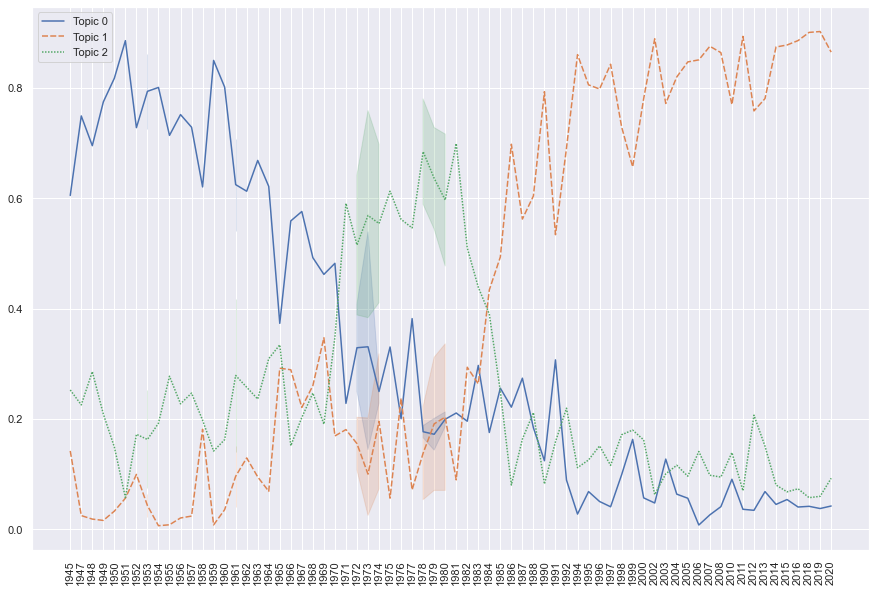

In [22]:
costum_plot(nmf_model, tf_fit, 30)

Use `pyLDAvis` to plot Intertopic Distance Map of Topics and Top-30 Most Relevant Terms for each topic 

In [19]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(nmf_model, tf_fit, tf_vectorizer_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.224894  0.038572       1        1  40.152852
0     -0.068610 -0.167697       2        1  34.608654
2     -0.156284  0.129125       3        1  25.238494, topic_info=            Term      Freq     Total Category  logprob  loglift
4038       shall  4.000000  4.000000  Default  30.0000  30.0000
4518     tonight  6.000000  6.000000  Default  29.0000  29.0000
739    communist  2.000000  2.000000  Default  28.0000  28.0000
4456       thank  2.000000  2.000000  Default  27.0000  27.0000
4450   terrorist  2.000000  2.000000  Default  26.0000  26.0000
...          ...       ...       ...      ...      ...      ...
2601  management  1.004451  2.110373   Topic3  -6.2268   0.6344
2883     natural  0.898542  1.602317   Topic3  -6.3382   0.7984
3493     propose  0.969060  2.638983   Topic3  -6.2627   0.3750
50      activity  0.905823  1.796742   Topic3  -6.3302   0.6919
726   commission  0.883615  1.899239   Topic3  -6.3550   0.6116

[277 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
10        3  1.068120           abuse
50        2  0.556563        activity
50        3  0.556563        activity
59        3  0.744592        addition
65        2  0.664965        adequate
...     ...       ...             ...
4670      3  0.682837           urban
4715      1  0.549615         vietnam
4715      2  0.549615         vietnam
4819      2  0.722329           whole
4876      1  1.173074  working family

[170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])